# Regresja logistyczna

Regresja logistyczna jest algorytmem klasyfikacji uczenia maszynowego, który jest używany do przewidywania prawdopodobieństwa kategorycznej zmiennej zależnej. W regresji logistycznej, zmienna zależna jest zmienną binarną, która zawiera dane zakodowane jako 1 (tak, sukces, itp.) lub 0 (nie, porażka, itp.). Innymi słowy, model regresji logistycznej przewiduje P(Y=1) jako funkcję X.

Skoro w nazwie jest słowo regresja, to czemu ten model jest jednak algorytmem klasyfikacji? Regresja sama w sobie przewiduje prawdopodobieństwo przynależności do danej klasy, co samo w samo jest problemem regresji. Natomiast to prawdopodobienstwo jest zamieniane od pewnego progu np p>-0.5 dla klasę 1, oraz 0 w przeciwnym wypadku.



## Ważne informacje

- Używamy regresji logistycznej, aby wytrenować model do przewidywania między 2 klasami: Yes/No, Black/White, True/False. 
- Żadna zmienna zależna(**y**) nie powinna znajdować się wśród zestawu cech(**X**). Należy zbadać korelację pomiędzy cechami oddzielnie.
- Dane wejściowe(**X**) zostaną poddane normalizacji i standaryzacji.
Wyjściem regresji logistycznej jest zawsze log prawdopodobieństwa. 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from matplotlib.gridspec import GridSpec

from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, precision_score

from sklearn import model_selection, tree, linear_model, neighbors, naive_bayes, ensemble
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate

import lightgbm as lgb
from sklearn.model_selection import train_test_split



import numpy.random as npr
import scipy.stats as stats

# formulat interface to statsmodels (standard linear models)
import statsmodels.formula.api as smf

from scipy.cluster.vq import vq, kmeans
import matplotlib.patches as mpatches
from collections import defaultdict

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn import preprocessing  # to normalise existing X

In [ ]:
#titanic.csv
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"

data = pd.read_csv(url)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Tworzenie nowych cech

In [ ]:
#tworzenie zmiennej binarnej

In [ ]:
data["if_child"] = data['Age'].apply(lambda x: 1 if x<15 else 0) # 1 znaczy dziecko, 0 oznacza dorolsy

In [ ]:
data['if_child'].value_counts()

0    813
1     78
Name: if_child, dtype: int64

In [ ]:
#tworzenie dowolnej liczby klas

def separate_age(age):
  if age<15:
    return "kid"
  elif age <65:
    return "adult"
  else:
    return "old"

data["Age"].map(separate_age)


0      adult
1      adult
2      adult
3      adult
4      adult
       ...  
886    adult
887    adult
888      old
889    adult
890    adult
Name: Age, Length: 891, dtype: object

In [ ]:
#zmienne można łączyć(nie zawsze sie to udaje, zmienne musza miec ten sam typ)
data["Ticket"]+data["Embarked"]



0             A/5 21171S
1              PC 17599C
2      STON/O2. 3101282S
3                113803S
4                373450S
             ...        
886              211536S
887              112053S
888          W./C. 6607S
889              111369C
890              370376Q
Length: 891, dtype: object

In [ ]:
#zadanko
#stworzyc zmienna family na podstawie zmiennych SibSp	Parch
#sprawdzic czy kobiety na statku mialy srednio wiecej czlonkow rodziny niz mezczyzni, mozesz uzyc funkcji groupby

In [ ]:
data.groupby(['Pclass', 'Sex', 'if_child', 'Survived']).count()['PassengerId']

Pclass  Sex     if_child  Survived
1       female  0         0             2
                          1            90
                1         0             1
                          1             1
        male    0         0            77
                          1            42
                1         1             3
2       female  0         0             6
                          1            60
                1         1            10
        male    0         0            91
                          1             8
                1         1             9
3       female  0         0            58
                          1            59
                1         0            14
                          1            13
        male    0         0           282
                          1            38
                1         0            18
                          1             9
Name: PassengerId, dtype: int64

# Opis statystyczny zmiennej

In [ ]:
def statistical_description(df, col):

  mode, median, mean = df[col].mode()[0], df[col].median(), df[col].mean()
  q1, q3, var, std, skew, kur = df[col].quantile(0.25), df[col].quantile(0.75), df[col].var(), df[col].std(), df[col].skew(), df[col].kurtosis()
  irq = q3-q1

  statistics = [mean,  q1, q3, var, std, skew, kur, irq]
  statistics = [round(x,3) for x in statistics]

  param = stats.norm.fit(df[col])   # Dopasowanie rozkladu normalnego do danych 
  x1, x2 =  mean-3*std, mean+3*std
  N = len(df[col])
  x = np.linspace(x1,x2, N)
  pdf_fitted = stats.norm.pdf(x, *param)

      
  plt.plot(x, pdf_fitted, color='green')
  df[col].plot(kind='hist', figsize=(10, 8), linewidth=2 , color='whitesmoke', edgecolor='gray', density=True)
  plt.xlabel(str(col), labelpad=15)
  plt.ylabel("Gęstość")
  plt.title("Rozkład zmiennej {}".format(col), y=1.012, fontsize=22)
  measurements = [mode, median, mean, q1, q3, mean-3*std, mean+3*std]
  # measurement = [round(x, 3) for x in measurement]




  names = ["mode", "median", "mean", "q1", "q3", "x-3*std", "x+3*std"]
  colors = ['green', 'blue', 'orange', 'blue', 'blue', 'red', 'red']

  for measurement, name, color in zip(measurements, names, colors):
    plt.axvline(x=measurement, linestyle='--', linewidth=2.5, label='{0} at {1}'.format(name, measurement), c=color)
    plt.legend();
  plt.show()
  print("statistics mean={}, q1={}, q3={}, var={}, std={}, skew={}, kurtosis={}, IRQ={}".format(*statistics))

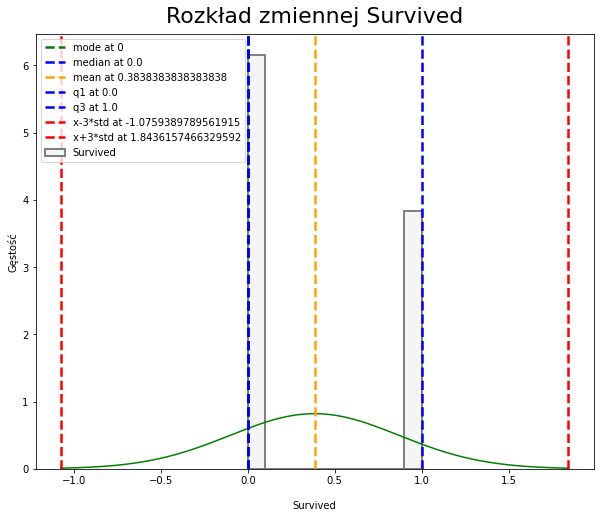

statistics mean=0.384, q1=0.0, q3=1.0, var=0.237, std=0.487, skew=0.479, kurtosis=-1.775, IRQ=1.0


In [ ]:
col = 'Survived'


statistical_description(data, col)

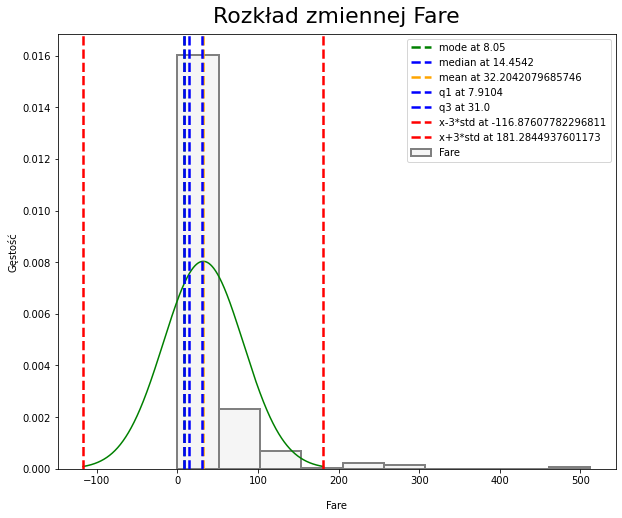

statistics mean=32.204, q1=7.91, q3=31.0, var=2469.437, std=49.693, skew=4.787, kurtosis=33.398, IRQ=23.09


In [ ]:
statistical_description(data, "Fare")

# Transformacje danych

In [ ]:
def normalization(df):
	    normalized = df.apply(lambda x: x/max(x))
	    return normalized
	
def standarization(df):
    standarized = df.apply(lambda x: (x - x.mean()) /max(x))
    return standarized

# def logarization(df, col):
#   df[col] = np.log2(df[col])
#   return df

In [ ]:
#zlogarytmuj zmienna "Fare" i zobacz jak ona wyglada po transformacji, zastanow sie czemu jest problem z wykonaniem tej operacji

# statistical_description(data, "Fare")

# Sprawdzanie zalożen

In [ ]:
def czy_normalny(df, col, alpha):
  stat, p  = stats.shapiro(df[col])
  if p > alpha:
    print('Dane mają rozkład normalny (nie odrzucamy H0)')
  else:
    print('Dane nie mają rozkładu normalnego')

In [ ]:
czy_normalny(data, "Fare", 0.05)

Dane nie mają rozkładu normalnego


In [ ]:
#zadanie, sprawdz, ktore zmienne ze zmeinnej data maja rozklad normalny, pokazac ich wykres rozkladu wraz z naniesiona moda, mediana, kwartylem 1 i 3

## Informacje o datasecie

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  if_child     891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [ ]:
data.shape

(891, 13)

In [ ]:
def dataframe_metainformation(df):
    meta = dict()
    descr = pd.DataFrame({'dtype': df.dtypes, 'NAs': df.isna().sum()})
    categorical_features = descr.loc[descr['dtype'] == 'object'].index.values.tolist()
    numerical_features = descr.loc[descr['dtype'] != 'object'].index.values.tolist()
    numerical_features_na = descr.loc[(descr['dtype'] != 'object') & (descr['NAs'] > 0)].index.values.tolist()
    categorical_features_na = descr.loc[(descr['dtype'] == 'object') & (descr['NAs'] > 0)].index.values.tolist()
    complete_features = descr.loc[descr['NAs'] == 0].index.values.tolist()
    meta['description'] = descr
    meta['categorical_features'] = categorical_features
    meta['categorical_features'] = categorical_features
    meta['categorical_features_na'] = categorical_features_na
    meta['numerical_features'] = numerical_features
    meta['numerical_features_na'] = numerical_features_na
    meta['complete_features'] = complete_features
    return meta

def print_metainformation(meta):
    print('Available types:', meta['description']['dtype'].unique())
    print('{} Features'.format(meta['description'].shape[0]))
    print('{} categorical features'.format(len(meta['categorical_features'])))
    print('{} numerical features'.format(len(meta['numerical_features'])))
    print('{} categorical features with NAs'.format(len(meta['categorical_features_na'])))
    print('{} numerical features with NAs'.format(len(meta['numerical_features_na'])))
    print('{} Complete features'.format(len(meta['complete_features'])))

In [ ]:
meta = dataframe_metainformation(data)
print_metainformation(meta)

Available types: [dtype('int64') dtype('O') dtype('float64')]
13 Features
5 categorical features
8 numerical features
2 categorical features with NAs
1 numerical features with NAs
10 Complete features


In [ ]:
def na_handling(df, name_of_strategy,specific_value="0"):
  """
  Uzupełnianie braków w kolumnach wg określonej strategii:
  - mean - uzupełnianie braków za pomocą średniej, stosuje się tylko dla danych ilościowych
  - mode - uzupełnianie braków za pomocą mody, raczej dla wartości dyskretnych, można stosować dla danych kategorycznych
  - 0 - uzupełnianie braków za pomocą 0, stosuje się w przypadku, gdzie wartość 0 ma jasną interpretację.
  - specific value - uzywamy w przypadku gdy chcemy użyć jakieś customowej wartości, np 33 lub dwa, ważne żeby wartość była tego samego typu co uzupełniania kolumna.
  - next_row, previous_row
  
  """

  if name_of_strategy=="previous_row":
    df.fillna(method="backfill", inplace=True)
    return df
  elif name_of_strategy=="next_row":
    df.fillna(method="ffill", inplace=True)
    return df
  elif name_of_strategy=="0":
    df.fillna(0, inplace=True)
    return df
  elif name_of_strategy=="specific_value":
    df.fillna(spefic_value, inplace=True)
    return df
  

  elif name_of_strategy=="mean":
    df.fillna(df.mean(), inplace=True)
    return df
  elif name_of_strategy=="mode":
    df.fillna(df.mode(dropna=True), inplace=True)
    return df
  else:
    print("Wrong specified strategy")

In [ ]:
#Uzupelnienie brakow przez mode

fill_mode = lambda col: col.fillna(col.mode().iloc[0])
data = data.apply(fill_mode, axis=0)

In [ ]:
#Sprawdzamy czy rzeczywiscie uzupelnilismy braki
meta = dataframe_metainformation(data)
print_metainformation(meta)

Available types: [dtype('int64') dtype('O') dtype('float64')]
13 Features
5 categorical features
8 numerical features
0 categorical features with NAs
0 numerical features with NAs
13 Complete features


Sprawdzamy zbalansowanie zmiennej przewidywanej

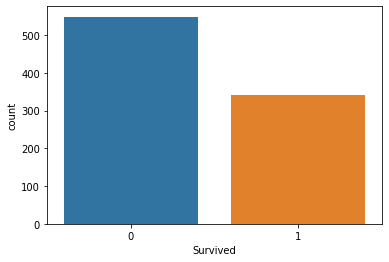

In [ ]:
sns.countplot(x='Survived', data=data);
plt.show();

# Kodowanie zmiennych

In [ ]:
#customowe kodowanie
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,if_child
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,B96 B98,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,B96 B98,S,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0


In [ ]:
mapping_dict = {"male": 11, "female": 22}
data["Sex_enc"] = data["Sex"].map(mapping_dict)


In [ ]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,if_child,Sex_enc
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,0,11
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,22
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,0,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,22
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,B96 B98,S,0,11
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0,22
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,B96 B98,S,0,22
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,11


In [ ]:
#kodowanie danych zmiennych kategorycznych - One hot encoding 

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [ ]:
data_enc = encode_and_bind(data, "Sex")
data_enc

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,if_child,Sex_enc,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,S,0,11,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0,22,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,0,22,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,0,22,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,S,0,11,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,B96 B98,S,0,11,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,S,0,22,1,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",24.0,1,2,W./C. 6607,23.4500,B96 B98,S,0,22,1,0
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,C,0,11,0,1


In [ ]:
#uzywanie label encodera, nie zalecane w ogolnosci, pokzauje dla tego pokazac, ze klasa sama w sobie istnieje
def encode_to_num_df(df):
  from sklearn.preprocessing import LabelEncoder
  df = df.apply(LabelEncoder().fit_transform)
  return df


def decode_label_df(df, le):
  df = df.apply(le.inverse_transform)
  return df


def encode_single_column(df, col_name):
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  df[col_name] = le.fit_transform(df[col_name])
  return df


def decode_single_column(df, col_name, le):
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  df[col_name] = le.inverse_transform(df[col_name])
  return df	


def encode_to_num_df(col: pd.Series):
  """
  Sample usage:
  mapping_encoding = []
  for name in X.columns:
    df_enc[name], d = encode_to_num_df(X[name])
    mapping_encoding.append(d)
  
  
  """
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  col_enc = le.fit_transform(col)
  d = dict(zip(le.transform(le.classes_),le.classes_))
  return col_enc, d

In [ ]:
#zakoduj zmienna Embarked customowym kodowaniem, C ma byc Francja, Q = Nowa Zelandia, S = Anglia(zamiena by bylo bardziej czytelnie)
#Mozesz potem przekodowac je na one-hot-encoding

# Selekcja zmiennych

### Recursive Feature Elimination
Recursive Feature Elimination (RFE) opiera się na idei wielokrotnego konstruowania modelu i wybierania cechy o najlepszych lub najgorszych wynikach, odkładania jej na bok i powtarzania procesu z pozostałymi cechami. Proces ten jest stosowany do momentu, gdy wszystkie cechy w zbiorze danych zostaną wyczerpane. Celem RFE jest wybór cech poprzez rekurencyjne rozpatrywanie coraz mniejszych zbiorów cech.

In [ ]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

X = data_enc[X_selected]
y = data_enc["Survived"]


logreg = LogisticRegression(solver='lbfgs', max_iter=250)
rfe = RFE(logreg, n_features_to_select=4) 
rfe = rfe.fit(X, y)

selectK_mask=rfe.get_support()
K_featnames = np.array(X_selected)[selectK_mask]
print("Wybrane kolumny", list(K_featnames))

Wybrane kolumny ['Pclass', 'SibSp', 'Sex_female', 'Sex_male']


In [ ]:

#dodaj do wybranych kolumn zmienna Embarked, zakoduj sa kodowaniem one-hot(mozesz uzyc rozwiazania z zadania wczesniej) i sprawdz czy to zmieni wynik RFE
#masz jakies wnioski?


In [ ]:
# Używamy pakietu `statmodels`, ponieważ chcemy mieć łatwy dostęp do wszystkich wskaźników statystycznych, do których może prowadzić regresja logistyczna

In [ ]:

X = data_enc[list(K_featnames)]
y = data_enc["Survived"]

logit_model=sm.Logit(y, X)
result=logit_model.fit(method='bfgs')
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.459774
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.310     
Dependent Variable: Survived         AIC:              827.3182  
Date:               2022-06-14 05:30 BIC:              846.4875  
No. Observations:   891              Log-Likelihood:   -409.66   
Df Model:           3                LL-Null:          -593.33   
Df Residuals:       887              LLR p-value:      2.6269e-79
Converged:          1.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Pclass        -0.9389    0.1065  -8.8183  0.0000  -1.1476  -0.7302
SibSp         -0.2481    0.0945  -2.6244  0.0087  -0.4334 

### P-Values and feature selection

Usuwamy zmienne p>0.05, jako nieistotne statystycznie



In [ ]:
to_remove = result.pvalues[result.pvalues > 0.05].index.tolist()
X.drop(to_remove, inplace=True, axis=1)

logit_model=sm.Logit(y, X)
result=logit_model.fit(method='bfgs')
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.459774
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.310     
Dependent Variable: Survived         AIC:              827.3182  
Date:               2022-06-14 05:30 BIC:              846.4875  
No. Observations:   891              Log-Likelihood:   -409.66   
Df Model:           3                LL-Null:          -593.33   
Df Residuals:       887              LLR p-value:      2.6269e-79
Converged:          1.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Pclass        -0.9389    0.1065  -8.8183  0.0000  -1.1476  -0.7302
SibSp         -0.2481    0.0945  -2.6244  0.0087  -0.4334 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#tak przefiltrowane dane możemy wrzucić do modelu

In [ ]:
#logistyczna regresja

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy on test: {:.2f}'.format(logreg.score(X_test, y_test)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on test: 0.79
[[144  24]
 [ 31  69]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       168
           1       0.74      0.69      0.72       100

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268



# Redukcja wymiarow poprzez korelacje

In [ ]:
def show_heatmap(df, method):
  plt.figure(figsize=(12,10))
  cor = df.corr(method = method)
  sns.heatmap(cor, annot=True)
  return cor
  plt.show()

Pclass     0.339668
Fare       0.323736
Sex_enc    0.543351
Name: Survived, dtype: float64

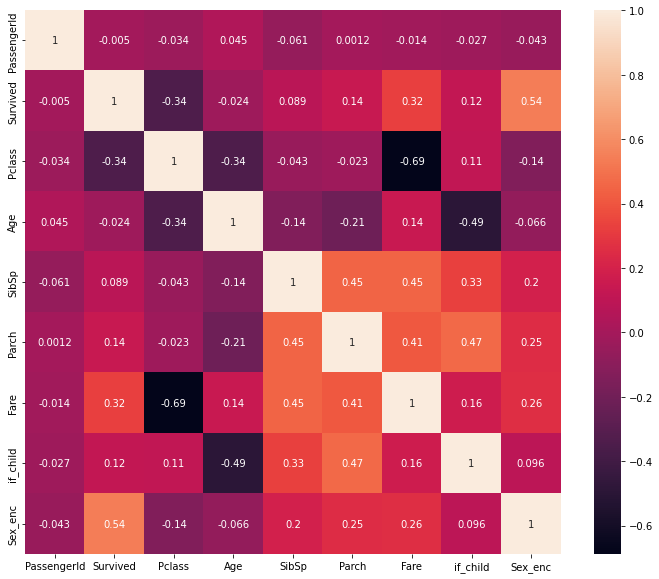

In [ ]:
cor = show_heatmap(data,'spearman')
target_name = 'Survived'
cor_target = abs(cor[target_name])
high_corr = cor_target[(cor_target>0.2) & (cor_target!=1) ]
high_corr

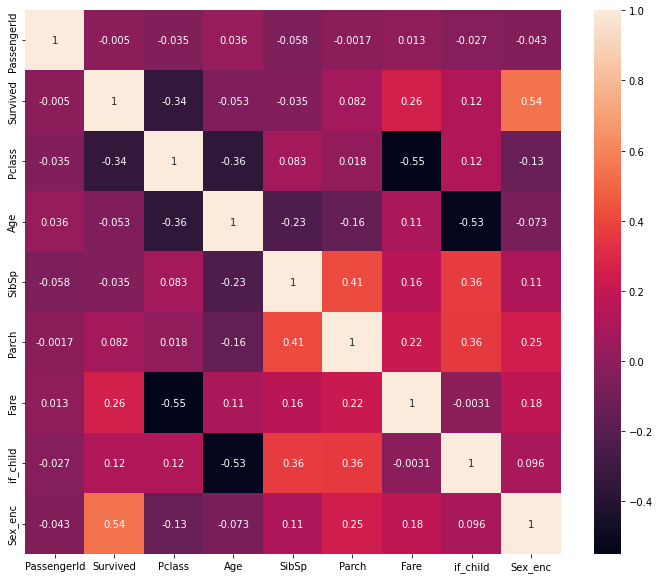

In [ ]:
cor = show_heatmap(data,'pearson')


In [ ]:
#Jesli potrzeba, mozemy usunac zmienne ze zbyt duza korelacja wzajemna
def remove_collinear_var(df,threshold=0.9):
		"""Remove Collinear Variables"""
		corr_matrix = df.corr().abs()
		upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
		to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
		result = df.drop(columns = to_drop, inplace=True)
		return result



### Krzywa ROC

Krzywa ROC (receiver operating characteristic) jest kolejnym narzędziem powszechnie stosowanym w przypadku klasyfikatorów binarnych. Linia przerywana przedstawia krzywą ROC czysto losowego klasyfikatora; dobry klasyfikator znajduje się jak najdalej od tej linii (w kierunku lewego górnego rogu).

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

Plot the FPR vs. TPR, and the diagonal line representing the null model.

In [ ]:
def plot_roc(fpr, tpr, logit_roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    # plt.savefig('Log_ROC')
    plt.show();

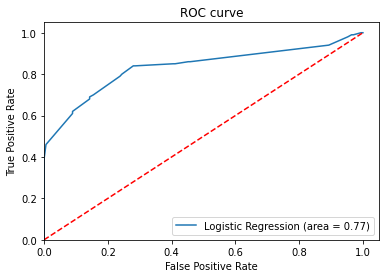

In [ ]:
plot_roc(fpr, tpr, logit_roc_auc)

In [ ]:
cv = 5

cv_results = cross_validate(logreg, X, y, cv=cv, scoring='roc_auc')
mean_auc = round(np.mean(cv_results['test_score']),2)
std_auc = round(np.std(cv_results['test_score']),2)
print("AUC dla cv={} i {} {}+-{}".format(cv, logreg.__class__.__name__, mean_auc, 3*std_auc))

AUC dla cv=5 i LogisticRegression 0.84+-0.03


### Explore logit predictions

Szukamy optymalnego punktu odciecia

In [ ]:
pred_proba_df = pd.DataFrame(logreg.predict_proba(X_test))
threshold_list = np.arange(0.05, 1.0, 0.05)
accuracy_list = np.array([])
for threshold in threshold_list:
    y_test_pred = pred_proba_df.applymap(lambda prob: 1 if prob > threshold else 0)
    test_accuracy = accuracy_score(y_test.values,
                                   y_test_pred[1].values.reshape(-1, 1))
    accuracy_list = np.append(accuracy_list, test_accuracy)

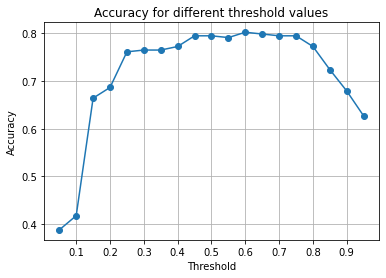

In [ ]:
plt.plot(range(accuracy_list.shape[0]), accuracy_list, 'o-', label='Accuracy')
plt.title('Accuracy for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.xticks([i for i in range(1, accuracy_list.shape[0], 2)], 
           np.round(threshold_list[1::2], 1))
plt.grid()
plt.show();

In [ ]:
MLA = [logreg, 
       
    ]

In [ ]:
def compare_algorithms2df(MLA, X_train, X_test, y_train, y_test, sorted_by_measure='accuracy'):
  #show grid with compared results - accuracy, recall, ppv, f1-measure, mcc
  
  MLA_columns = []
  MLA_compare = pd.DataFrame(columns = MLA_columns)


  row_index = 0
  for alg in MLA:

    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    MLA_compare.loc[row_index, 'MLA Precission'] = precision_score(y_test, predicted)
    MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(y_test, predicted)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)
    row_index+=1
  
  MLA_compare.sort_values(by = ['MLA AUC'], ascending = False, inplace = True)    
  return MLA_compare


def roc_curve_MLA(MLA,X_train, X_test, y_train, y_test):
  index = 1
  for alg in MLA:


      predicted = alg.fit(X_train, y_train).predict(X_test)
      fp, tp, th = roc_curve(y_test, predicted)
      roc_auc_mla = auc(fp, tp)
      MLA_name = alg.__class__.__name__
      plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)'  % (MLA_name, roc_auc_mla))

      index+=1

  plt.title('ROC Curve comparison')
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')    
  plt.show()

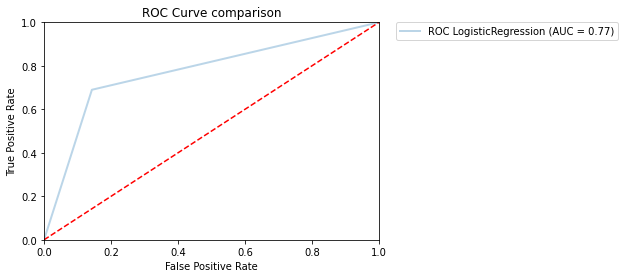

In [ ]:
roc_curve_MLA(MLA,X_train, X_test, y_train, y_test)

In [ ]:
df_ml = compare_algorithms2df(MLA,X_train, X_test, y_train, y_test)
df_ml

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precission,MLA Recall,MLA AUC
0,LogisticRegression,0.8026,0.7948,0.741935,0.69,0.773571
